# Mammogram Classification

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

### Reading and Understanding Data

In [2]:
raw_df = pd.read_csv('mammographic_masses.data.txt', na_values='?', names = ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity' ])
## Reading CSV, replacing missing values with NaN and manually adding column labels

In [3]:
raw_df.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [4]:
raw_df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [5]:
## BI_RADS = Ordinal data (1-5): confidence of severity classification; non-predictive 
## Age = Patient's age in years 
## Shape = Shape of the mass: round = 1, oval = 2, lobular = 3, irregular = 4
## Margin = Mass margins: circumscribed = 1, microlobulated = 2, obscured = 3, ill-defined = 4, spiculated = 5
## Density = Mass density: high = 1, iso = 2, low = 3, fat-containing = 4, 
## Severity = Prediction label: benign = 0, malignant = 1

### Data Pre-processing

In [6]:
df = raw_df.drop(columns = ['BI_RADS'])
## Non-predictive as denotes confidence of predictions

In [7]:
df.describe()

,age,shape,margin,density,severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [8]:
na_df = df.loc[df.isnull().any(axis=1)]
na_df

,age,shape,margin,density,severity
1,43.0,1.0,1.0,NaN,1
4,74.0,1.0,5.0,NaN,1
5,65.0,1.0,NaN,3.0,0
6,70.0,NaN,NaN,3.0,0
7,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...
778,60.0,NaN,4.0,3.0,0
819,35.0,3.0,NaN,2.0,0
824,40.0,NaN,3.0,4.0,1
884,NaN,4.0,4.0,3.0,1


In [9]:
df.corr()

,age,shape,margin,density,severity
age,1.000000,0.364077,0.411355,0.028954,0.432066
shape,0.364077,1.000000,0.742211,0.078666,0.563308
margin,0.411355,0.742211,1.000000,0.109392,0.574919
density,0.028954,0.078666,0.109392,1.000000,0.064010
severity,0.432066,0.563308,0.574919,0.064010,1.000000


<AxesSubplot:>

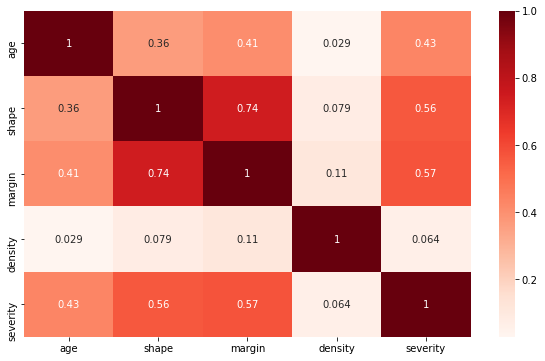

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='Reds', annot=True)

In [11]:
## Severity which has high correlation coefficients doesn't have any missing data
## Density which has the most missing data, has low correlation coefficients
## Remaining variables have moderately low coefficients and low amount of missing data
## Therefore, data largely missing at random

In [12]:
df = df.dropna()
df = df.reset_index(drop=True)

In [13]:
df

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,58.0,4.0,5.0,3.0,1
2,28.0,1.0,1.0,3.0,0
3,57.0,1.0,5.0,3.0,1
4,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
826,47.0,2.0,1.0,3.0,0
827,56.0,4.0,5.0,3.0,1
828,64.0,4.0,5.0,3.0,0
829,66.0,4.0,5.0,3.0,1


In [14]:
df_x = df.drop(columns = ['severity'])
df_x

,age,shape,margin,density
0,67.0,3.0,5.0,3.0
1,58.0,4.0,5.0,3.0
2,28.0,1.0,1.0,3.0
3,57.0,1.0,5.0,3.0
4,76.0,1.0,4.0,3.0
...,...,...,...,...
826,47.0,2.0,1.0,3.0
827,56.0,4.0,5.0,3.0
828,64.0,4.0,5.0,3.0
829,66.0,4.0,5.0,3.0


In [15]:
df_y = df.drop(columns = ['age', 'shape', 'margin', 'density'])
df_y

,severity
0,1
1,1
2,0
3,1
4,1
...,...
826,0
827,1
828,0
829,1


In [16]:
array_x = df_x.to_numpy()
array_y = df_y.to_numpy()
labels = df_x.columns.to_numpy()

In [17]:
array_x

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

In [18]:
array_y

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
    

In [19]:
labels

array(['age', 'shape', 'margin', 'density'], dtype=object)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
normalised_x = scaler.fit_transform(array_x)

In [21]:
normalised_x

array([[ 0.76580356,  0.17445989,  1.39563127,  0.24031298],
       [ 0.15166622,  0.97988304,  1.39563127,  0.24031298],
       [-1.89545824, -1.43638642, -1.15892729,  0.24031298],
       ...,
       [ 0.56109111,  0.97988304,  1.39563127,  0.24031298],
       [ 0.69756608,  0.97988304,  1.39563127,  0.24031298],
       [ 0.42461615,  0.17445989,  0.11835199,  0.24031298]])

In [22]:
np.mean(normalised_x, axis=0, dtype = 'float64')

array([-1.21843971e-16, -2.99265894e-17, -9.40549951e-17,  5.08752019e-16])

In [23]:
np.std(normalised_x, axis=0, dtype = 'float64')

array([1., 1., 1., 1.])

### Splitting into Train & Test Data

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=75)

### Comparing Results

In [25]:
## Write a function to compare common metrics in a matrix (accuracy, AUC, precision, recall, F1 score)
## Specific metrics for specific models
## Append to a dataframe

In [26]:
index = {'decision_tree', 'random_forest', 'XGBoost', 'SVM', 'Naive_Bayes', 'KNN', 'Simple NN', 'Deep NN'}
results = {'balanced_accuracy_score': [0, 0, 0, 0, 0, 0, 0, 0], 'precision_score': [0, 0, 0, 0, 0, 0, 0, 0], 'recall_score': [0, 0, 0, 0, 0, 0, 0, 0], 'f1_score': [0, 0, 0, 0, 0, 0, 0, 0], 'cross_val_score': [0, 0, 0, 0, 0, 0, 0, 0]}
results_df = pd.DataFrame(data=results, index=index)
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0,0,0,0,0
Deep NN,0,0,0,0,0
KNN,0,0,0,0,0
Naive_Bayes,0,0,0,0,0
XGBoost,0,0,0,0,0
random_forest,0,0,0,0,0
decision_tree,0,0,0,0,0
SVM,0,0,0,0,0


In [27]:
def results(y_test, y_pred, normalised_x, array_y, average, classifier):
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.model_selection import cross_val_score

    balanced_accuracy_score = balanced_accuracy_score(y_test, y_pred)
    precision_score = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall_score = recall_score(y_test, y_pred, average=average, zero_division=1)
    f1_score = f1_score(y_test, y_pred, average=average, zero_division=1)
    cross_val_score = cross_val_score(classifier, normalised_x, array_y).mean()

    return np.array((balanced_accuracy_score, precision_score, recall_score, f1_score,cross_val_score))

## Training 

### Decision Tree

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=0)

In [29]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)

In [30]:
y_pred = dt_clf.fit(x_train, y_train.ravel()).predict(x_test)

In [31]:
dt = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=DecisionTreeClassifier(random_state=0))

In [32]:
dt

array([0.7736774 , 0.77414138, 0.77403846, 0.77392866, 0.71599452])

In [33]:
results_df.loc[['decision_tree']] = dt

In [34]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000
Naive_Bayes,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000
random_forest,0.000000,0.000000,0.000000,0.000000,0.000000
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.000000,0.000000,0.000000,0.000000,0.000000


### Random Forest

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=0)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [37]:
x_train, y_train = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

In [38]:
rnd_clf = RandomForestClassifier(max_depth=2, random_state=0)

In [39]:
rnd_clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [40]:
y_pred = rnd_clf.fit(x_train, y_train.ravel()).predict(x_test)

In [41]:
rnd = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=RandomForestClassifier(max_depth=2, random_state=1))

In [42]:
results_df.loc[['random_forest']] = rnd

In [43]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000
Naive_Bayes,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.000000,0.000000,0.000000,0.000000,0.000000


### XGBoost

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=0)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
XGB_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0).fit(x_train, y_train.ravel())

In [46]:
y_pred = XGB_clf.fit(x_train, y_train.ravel()).predict(x_test)

In [47]:
XGBoost = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=XGB_clf)

In [48]:
results_df.loc[['XGBoost']] = XGBoost

In [89]:
x = [[-1.89545824, -1.43638642, -1.15892729,  0.24031298]]

In [90]:
XGB_clf.predict(x)

array([0])

In [49]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000
Naive_Bayes,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.000000,0.000000,0.000000,0.000000,0.000000


### SVM

In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=0)

In [51]:
from sklearn.svm import SVC

In [52]:
SVM_clf = SVC(gamma = 'auto')

In [53]:
SVM_clf.fit(x_train, y_train.ravel())

SVC(gamma='auto')

In [54]:
y_pred = SVM_clf.fit(x_train, y_train.ravel()).predict(x_test)

In [55]:
SVM = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=SVM_clf)

In [56]:
results_df.loc[['SVM']] = SVM

In [57]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000
Naive_Bayes,0.000000,0.000000,0.000000,0.000000,0.000000
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.837403,0.839973,0.836538,0.836312,0.806313


### Naive Bayes

In [58]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.1, random_state=0)

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
gnb = GaussianNB()

In [61]:
y_pred = gnb.fit(x_train, y_train.ravel()).predict(x_test)

In [62]:
incorrect = (y_test.ravel() != y_pred.ravel()).sum()

In [63]:
score = 1 - incorrect / y_pred.shape[0]
score

0.8452380952380952

In [64]:
GNB = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=gnb)

In [65]:
results_df.loc[['Naive_Bayes']] = GNB

In [66]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.000000,0.000000,0.000000,0.000000,0.000000
Naive_Bayes,0.857639,0.865934,0.845238,0.845831,0.782231
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.837403,0.839973,0.836538,0.836312,0.806313


### KNN

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.1, random_state=45)

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [70]:
neigh.fit(x_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=3)

In [71]:
neigh.score(x_train, y_train.ravel())

0.8514056224899599

In [72]:
neigh.score(x_test, y_test.ravel())

0.7023809523809523

In [73]:
y_pred = neigh.fit(x_train, y_train.ravel()).predict(x_test)

In [74]:
KNN = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=neigh)

In [75]:
results_df.loc[['KNN']] = KNN

In [76]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.000000,0.000000,0.000000,0.000000,0.000000
Deep NN,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,0.701361,0.702912,0.702381,0.701746,0.755761
Naive_Bayes,0.857639,0.865934,0.845238,0.845831,0.782231
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.837403,0.839973,0.836538,0.836312,0.806313


### Simple Neural Network

In [77]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normalised_x, array_y, test_size=0.25, random_state=0)

In [78]:
def create_simple_model():
    '''The function creates a Perceptron using Keras'''
    model = Sequential()
    model.add(Dense(20, input_dim=len(df_x.columns), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], loss='binary_crossentropy')

    return model

In [79]:
Simple_NN = create_simple_model()
Simple_NN.fit(x_train, y_train, epochs=250, validation_data=(x_test, y_test))

2022-05-29 12:45:20.334897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-29 12:45:20.336049: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Epoch 1/250
20/20 [==============================] - 1s 16ms/step - loss: 0.6173 - accuracy: 0.6901 - precision: 0.7348 - recall: 0.5632 - val_loss: 0.5533 - val_accuracy: 0.8029 - val_precision: 0.8081 - val_recall: 0.7843
Epoch 2/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5737 - accuracy: 0.7619 - precision: 0.7639 - recall: 0.7493 - val_loss: 0.5222 - val_accuracy: 0.8125 - val_precision: 0.8119 - val_recall: 0.8039
Epoch 3/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5369 - accuracy: 0.7758 - precision: 0.7903 - recall: 0.7504 - val_loss: 0.4983 - val_accuracy: 0.8125 - val_precision: 0.8058 - val_recall: 0.8137
Epoch 4/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5241 - accuracy: 0.7597 - precision: 0.7999 - recall: 0.7235 - val_loss: 0.4808 - val_accuracy: 0.8125 - val_precision: 0.8058 - val_recall: 0.8137
Epoch 5/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4981 - accuracy: 0.7789 - precis

2022-05-29 12:45:22.207792: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45:22.207852: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45:22.207866: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45

20/20 [==============================] - 0s 1ms/step - loss: 0.4117 - accuracy: 0.8162 - precision: 0.7726 - recall: 0.8493 - val_loss: 0.4423 - val_accuracy: 0.8606 - val_precision: 0.8174 - val_recall: 0.9216
Epoch 56/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.8047 - precision: 0.7586 - recall: 0.8553 - val_loss: 0.4428 - val_accuracy: 0.8558 - val_precision: 0.8103 - val_recall: 0.9216
Epoch 57/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7861 - precision: 0.7543 - recall: 0.8296 - val_loss: 0.4429 - val_accuracy: 0.8558 - val_precision: 0.8103 - val_recall: 0.9216
Epoch 58/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.8074 - precision: 0.7958 - recall: 0.8351 - val_loss: 0.4436 - val_accuracy: 0.8606 - val_precision: 0.8174 - val_recall: 0.9216
Epoch 59/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4717 - accuracy: 0.7822 - precision: 0.73

In [80]:
history = create_simple_model().fit(x_train, y_train, epochs=250, validation_data=(x_test, y_test))

Epoch 1/250
20/20 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.6417 - precision_1: 0.6583 - recall_1: 0.5826 - val_loss: 0.6310 - val_accuracy: 0.7596 - val_precision_1: 0.7500 - val_recall_1: 0.7647
Epoch 2/250
20/20 [==============================] - 0s 1ms/step - loss: 0.6151 - accuracy: 0.7617 - precision_1: 0.7182 - recall_1: 0.7838 - val_loss: 0.5866 - val_accuracy: 0.8125 - val_precision_1: 0.7788 - val_recall_1: 0.8627
Epoch 3/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5818 - accuracy: 0.7560 - precision_1: 0.7315 - recall_1: 0.7954 - val_loss: 0.5508 - val_accuracy: 0.8173 - val_precision_1: 0.7857 - val_recall_1: 0.8627
Epoch 4/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5474 - accuracy: 0.7835 - precision_1: 0.7413 - recall_1: 0.8072 - val_loss: 0.5218 - val_accuracy: 0.8173 - val_precision_1: 0.7857 - val_recall_1: 0.8627
Epoch 5/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5

2022-05-29 12:45:30.446550: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45:30.446597: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45:30.446606: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:45

Epoch 56/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8019 - precision_1: 0.7590 - recall_1: 0.8532 - val_loss: 0.4460 - val_accuracy: 0.8365 - val_precision_1: 0.7982 - val_recall_1: 0.8922
Epoch 57/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7962 - precision_1: 0.7609 - recall_1: 0.8288 - val_loss: 0.4454 - val_accuracy: 0.8413 - val_precision_1: 0.8000 - val_recall_1: 0.9020
Epoch 58/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.7734 - precision_1: 0.7448 - recall_1: 0.8281 - val_loss: 0.4470 - val_accuracy: 0.8365 - val_precision_1: 0.7982 - val_recall_1: 0.8922
Epoch 59/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4665 - accuracy: 0.7807 - precision_1: 0.7569 - recall_1: 0.8253 - val_loss: 0.4471 - val_accuracy: 0.8413 - val_precision_1: 0.8000 - val_recall_1: 0.9020
Epoch 60/250
20/20 [==============================] - 0s 1ms/step - loss

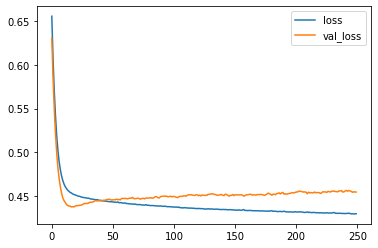

In [81]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [82]:
y_pred = Simple_NN.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [102]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
Keras_estimator = KerasClassifier(build_fn=create_model, epochs=250, verbose=0)

In [103]:
NN = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=Keras_estimator)

2022-05-29 12:57:21.922599: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:57:21.922661: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:57:21.922675: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:57

In [104]:
results_df.loc[['Simple NN']] = NN

In [105]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.847022,0.849659,0.846154,0.845940,0.797879
Deep NN,0.847022,0.849659,0.846154,0.845940,0.799091
KNN,0.701361,0.702912,0.702381,0.701746,0.755761
Naive_Bayes,0.857639,0.865934,0.845238,0.845831,0.782231
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.837403,0.839973,0.836538,0.836312,0.806313


## Deep Neural Network

In [92]:
def create_model():
    '''The function creates a Perceptron using Keras'''
    model = Sequential()
    model.add(Dense(16, input_dim=len(df_x.columns), activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], loss='binary_crossentropy')

    return model

In [93]:
#train the model
Deep_NN = create_model()
Deep_NN.fit(x_train, y_train, epochs=250, validation_data=(x_test, y_test))

Epoch 1/250
20/20 [==============================] - 1s 10ms/step - loss: 0.7092 - accuracy: 0.4782 - precision_2: 0.4659 - recall_2: 0.8812 - val_loss: 0.6696 - val_accuracy: 0.4808 - val_precision_2: 0.4853 - val_recall_2: 0.9706
Epoch 2/250
20/20 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5425 - precision_2: 0.5176 - recall_2: 0.9126 - val_loss: 0.6366 - val_accuracy: 0.7212 - val_precision_2: 0.6467 - val_recall_2: 0.9510
Epoch 3/250
20/20 [==============================] - 0s 1ms/step - loss: 0.6415 - accuracy: 0.6365 - precision_2: 0.5717 - recall_2: 0.8625 - val_loss: 0.6158 - val_accuracy: 0.8221 - val_precision_2: 0.7559 - val_recall_2: 0.9412
Epoch 4/250
20/20 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.6955 - precision_2: 0.6358 - recall_2: 0.8502 - val_loss: 0.6029 - val_accuracy: 0.8125 - val_precision_2: 0.7442 - val_recall_2: 0.9412
Epoch 5/250
20/20 [==============================] - 0s 1ms/step - loss: 0.

2022-05-29 12:55:47.158044: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55:47.158114: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55:47.158135: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55

20/20 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.7477 - precision_2: 0.7218 - recall_2: 0.7740 - val_loss: 0.4605 - val_accuracy: 0.8269 - val_precision_2: 0.8113 - val_recall_2: 0.8431
Epoch 56/250
20/20 [==============================] - 0s 2ms/step - loss: 0.4641 - accuracy: 0.7985 - precision_2: 0.7959 - recall_2: 0.7888 - val_loss: 0.4596 - val_accuracy: 0.8365 - val_precision_2: 0.8091 - val_recall_2: 0.8725
Epoch 57/250
20/20 [==============================] - 0s 2ms/step - loss: 0.4509 - accuracy: 0.7926 - precision_2: 0.7890 - recall_2: 0.7922 - val_loss: 0.4587 - val_accuracy: 0.8365 - val_precision_2: 0.8091 - val_recall_2: 0.8725
Epoch 58/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.8141 - precision_2: 0.8050 - recall_2: 0.8197 - val_loss: 0.4582 - val_accuracy: 0.8221 - val_precision_2: 0.8037 - val_recall_2: 0.8431
Epoch 59/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4636 - ac

In [94]:
history = create_model().fit(x_train, y_train, epochs=250, validation_data=(x_test, y_test))

Epoch 1/250
20/20 [==============================] - 1s 9ms/step - loss: 0.6798 - accuracy: 0.5122 - precision_3: 0.4976 - recall_3: 0.3176 - val_loss: 0.6291 - val_accuracy: 0.6346 - val_precision_3: 0.6300 - val_recall_3: 0.6176
Epoch 2/250
20/20 [==============================] - 0s 1ms/step - loss: 0.6392 - accuracy: 0.6374 - precision_3: 0.6050 - recall_3: 0.6351 - val_loss: 0.6076 - val_accuracy: 0.7837 - val_precision_3: 0.7244 - val_recall_3: 0.9020
Epoch 3/250
20/20 [==============================] - 0s 1ms/step - loss: 0.6169 - accuracy: 0.7293 - precision_3: 0.6796 - recall_3: 0.8055 - val_loss: 0.5848 - val_accuracy: 0.7981 - val_precision_3: 0.7419 - val_recall_3: 0.9020
Epoch 4/250
20/20 [==============================] - 0s 1ms/step - loss: 0.5802 - accuracy: 0.7817 - precision_3: 0.7400 - recall_3: 0.8286 - val_loss: 0.5575 - val_accuracy: 0.8221 - val_precision_3: 0.7826 - val_recall_3: 0.8824
Epoch 5/250
20/20 [==============================] - 0s 2ms/step - loss: 0.5

2022-05-29 12:55:58.491801: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55:58.491845: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55:58.491854: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-05-29 12:55

20/20 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7893 - precision_3: 0.7771 - recall_3: 0.8069 - val_loss: 0.4539 - val_accuracy: 0.8317 - val_precision_3: 0.8131 - val_recall_3: 0.8529
Epoch 56/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4573 - accuracy: 0.7965 - precision_3: 0.7914 - recall_3: 0.7997 - val_loss: 0.4555 - val_accuracy: 0.8365 - val_precision_3: 0.8148 - val_recall_3: 0.8627
Epoch 57/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4534 - accuracy: 0.7893 - precision_3: 0.7467 - recall_3: 0.8322 - val_loss: 0.4526 - val_accuracy: 0.8221 - val_precision_3: 0.8095 - val_recall_3: 0.8333
Epoch 58/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4410 - accuracy: 0.7832 - precision_3: 0.7641 - recall_3: 0.7889 - val_loss: 0.4549 - val_accuracy: 0.8317 - val_precision_3: 0.8131 - val_recall_3: 0.8529
Epoch 59/250
20/20 [==============================] - 0s 1ms/step - loss: 0.4758 - ac

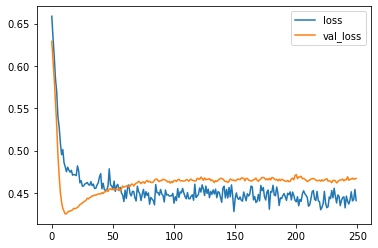

In [95]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.legend()

In [96]:
y_pred = Deep_NN.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [97]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
Keras_estimator = KerasClassifier(build_fn=create_model, epochs=250, verbose=0)

In [98]:
DNN = results(y_test, y_pred, normalised_x, array_y.ravel(), average='weighted', classifier=Keras_estimator)

2022-05-29 12:56:15.686349: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:56:15.686407: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:56:15.686420: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:993] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 966).
2022-05-29 12:56

In [99]:
results_df.loc[['Deep NN']] = DNN

In [130]:
results_df

,balanced_accuracy_score,precision_score,recall_score,f1_score,cross_val_score
Simple NN,0.847022,0.849659,0.846154,0.845940,0.797879
Deep NN,0.847022,0.849659,0.846154,0.845940,0.799091
KNN,0.701361,0.702912,0.702381,0.701746,0.755761
Naive_Bayes,0.857639,0.865934,0.845238,0.845831,0.782231
XGBoost,0.808361,0.809804,0.807692,0.807550,0.774987
random_forest,0.804014,0.808150,0.802885,0.802351,0.800289
decision_tree,0.773677,0.774141,0.774038,0.773929,0.715995
SVM,0.837403,0.839973,0.836538,0.836312,0.806313


## Saving trained models using pickle & keras

In [106]:
import pickle

In [115]:
filename = 'dt_clf.sav'
pickle.dump(dt_clf, open(filename, 'wb'))
## Save all models with relevant filenames

In [116]:
filename = 'rnd_clf.sav'
pickle.dump(rnd_clf, open(filename, 'wb'))
## Save all models with relevant filenames

In [117]:
filename = 'XGB_clf.sav'
pickle.dump(XGB_clf, open(filename, 'wb'))
## Save all models with relevant filenames

In [118]:
filename = 'SVM_clf.sav'
pickle.dump(SVM_clf, open(filename, 'wb'))
## Save all models with relevant filenames

In [119]:
filename = 'gnb.sav'
pickle.dump(gnb, open(filename, 'wb'))
## Save all models with relevant filenames

In [120]:
filename = 'neigh.sav'
pickle.dump(neigh, open(filename, 'wb'))
## Save all models with relevant filenames

In [121]:
tf.keras.models.save_model(Simple_NN, '/Users/eeshitapande/Simple_NN')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /Users/eeshitapande/Simple_NN/assets


In [122]:
tf.keras.models.save_model(Deep_NN, '/Users/eeshitapande/Deep_NN')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /Users/eeshitapande/Deep_NN/assets


### Predicting outcomes based on input and model selection

In [123]:
def predictions_simple(x, model_selection):
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=True, with_std=True)
    normalised_x = scaler.fit_transform(x)
    
    y = model_selection.predict(normalised_x)
    return y

In [124]:
def predictions(x, model_selection):
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(with_mean=True, with_std=True)
    x_norm = scaler.fit_transform(x)
    
    if model_selection == 'Simple_NN':
        loaded_model = tf.keras.models.load_model('/Users/eeshitapande/Simple_NN')
    elif model_selection == 'Deep_NN':
        loaded_model = tf.keras.models.load_model('/Users/eeshitapande/Deep_NN')
    elif model_selection == 'dt_clf':
        loaded_model = pickle.load(open('dt_clf.sav', 'rb'))
    elif model_selection == 'rnd_clf':
        loaded_model = pickle.load(open('rnd_clf.sav', 'rb'))
    elif model_selection == 'XGB_clf':
        loaded_model = pickle.load(open('XGB_clf.sav', 'rb'))
    elif model_selection == 'SVM_clf':
        loaded_model = pickle.load(open('SVM_clf.sav', 'rb'))
    elif model_selection == 'gnb':
        loaded_model = pickle.load(open('gnb.sav', 'rb'))
    elif model_selection == 'neigh':
        loaded_model = pickle.load(open('neigh.sav', 'rb'))
    else:
        print("Enter valid model name")
    
    y = loaded_model.predict(x_norm)
    y = np.where(y > 0.5, 1, 0)
    return y

In [ ]:
## Verify predictions manually using inputs
## Taking ensemble and predicting average?

In [136]:
x = 4
x = list(map(int, input("\nEnter the numbers : ").strip().split()))[:x]
x = np.asarray(x)
x = x.reshape(1,-1)
print(x)


Enter the numbers : 62 3 3 3
[[62  3  3  3]]


In [148]:
model_selection = input("Input your selected model (Simple_NN, Deep_NN, dt_clf (decision tree), rnd_clf (random forest), XGB_clf (XG Boost), SVM_clf (Support Vector Machines), gnb (Gaussian Naive Bayes), neigh (K Nearest Neighbours)): ")
# Enter model name from list of trained classifiers above

Input your selected model (Simple_NN, Deep_NN, dt_clf (decision tree), rnd_clf (random forest), XGB_clf (XG Boost), SVM_clf (Support Vector Machines), gnb (Gaussian Naive Bayes), neigh (K Nearest Neighbours)): SVM_clf


In [149]:
predictions(x, model_selection)

array([0])

In [135]:
df

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,58.0,4.0,5.0,3.0,1
2,28.0,1.0,1.0,3.0,0
3,57.0,1.0,5.0,3.0,1
4,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
826,47.0,2.0,1.0,3.0,0
827,56.0,4.0,5.0,3.0,1
828,64.0,4.0,5.0,3.0,0
829,66.0,4.0,5.0,3.0,1
